# Predicting Wine Quality

We want to develop a predictive model that can accurately assess or predict the quality score of a wine based solely on its measurable physicochemical properties.

we will be using the [Wine Quality Dataset](https://archive.ics.uci.edu/dataset/186/wine+quality) from the UCI Machine Learning Repository since it is suitable for our goal


In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



In [19]:
red = pd.read_csv("winequality-red.csv",sep=';')
white = pd.read_csv("winequality-white.csv",sep=';')

Now we are going to check which of the categories in these dataframes affect the quality of the wine the most

In [20]:
# Calculate the correlation matrix and sort by the 'quality' column
quality_correlations_red = red.corr()['quality'].sort_values(ascending=False)
quality_correlations_white = white.corr()['quality'].sort_values(ascending=False)

# Print the results
print("Quality Correlations for Red Wine: \n", quality_correlations_red, "\n")
print("Quality Correlations for White Wine: \n", quality_correlations_white)

Quality Correlations for Red Wine: 
 quality                 1.000000
alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
fixed acidity           0.124052
residual sugar          0.013732
free sulfur dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64 

Quality Correlations for White Wine: 
 quality                 1.000000
alcohol                 0.435575
pH                      0.099427
sulphates               0.053678
free sulfur dioxide     0.008158
citric acid            -0.009209
residual sugar         -0.097577
fixed acidity          -0.113663
total sulfur dioxide   -0.174737
volatile acidity       -0.194723
chlorides              -0.209934
density                -0.307123
Name: quality, dtype: float64


After running the correlations it seems like alcohol is the category that affects the quality of the wine the most, along with density and volatile acidity


We are going to combine these sets to make our analysis easier and more powerful

why? by combining both datasets we can train one model that learns patterns from both. we can also get more data which can help our model make better predictions

In [21]:
#adding a the type of wine column
red["type"] = "red"
white["type"] = "white"

#combining both dataframes
df = pd.concat([red, white], ignore_index=True)

print(df["type"].value_counts(), "\n")

type
white    4898
red      1599
Name: count, dtype: int64 



Now we are going to check for any missing values or outliers (using histogram and boxplot)

In [22]:
#Checking for missing values
print(df.isnull().sum(), "\n")

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
type                    0
dtype: int64 



Fortunately there is no missing values for any of the categories

Now we are going to check for any outliers for the alcohol category

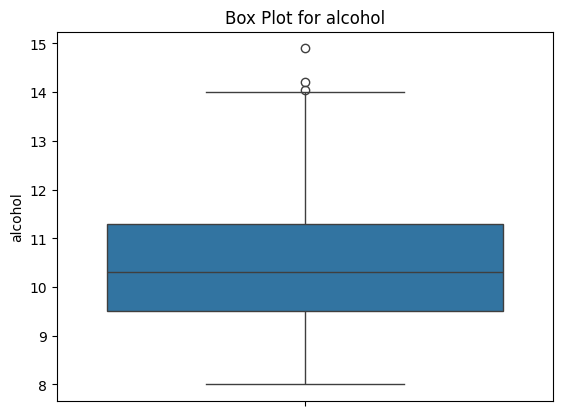

In [23]:
#Looking for outliers
sns.boxplot(y=df["alcohol"])
plt.title(f'Box Plot for alcohol')
plt.show()

In [24]:
# Filter the DataFrame for wines where 'alcohol' is greater than 14
outliers_df = df[df['alcohol'] > 14]

# Display the size of the outlier set and a sample of the data
print(f"Number of wines with alcohol > 14: {outliers_df.shape[0]}")
print("\nSample of wines with high alcohol content (Alcohol > 14):")
print(outliers_df[['alcohol', 'quality']].head())

# Check the range of quality scores for this high-alcohol group
if not outliers_df.empty:
    print(f"\nUnique quality scores for these high-alcohol wines: {sorted(outliers_df['quality'].unique())}")

Number of wines with alcohol > 14: 3

Sample of wines with high alcohol content (Alcohol > 14):
      alcohol  quality
652     14.90        5
5517    14.20        7
6102    14.05        7

Unique quality scores for these high-alcohol wines: [np.int64(5), np.int64(7)]


We are going to keep these three points because they represent a real-world variability in high-alcohol wines and provide critical information to the model about the features required to achieve or failing ot achieve high quality scores

# Do the rest of outlier check for `Density and volatile acidity` ^^^^^^^^^^

Now we are going to check if there is a relation between alcohol and wine quality by using a scatter plot

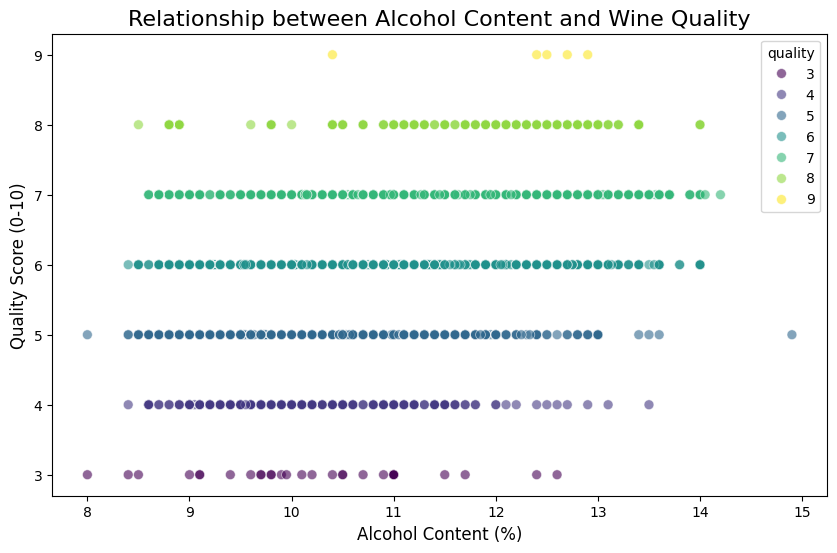

In [ ]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='alcohol', y='quality', data=df, alpha=0.6,
                s=50,  # size of points
                hue='quality',  # color points based on quality score
                palette='viridis') # color scheme

# Add labels and a title
plt.title('Relationship between Alcohol Content and Wine Quality', fontsize=16)
plt.xlabel('Alcohol Content (%)', fontsize=12)
plt.ylabel('Quality Score (0-10)', fontsize=12)

# Ensure the y-axis only shows integer quality scores
plt.yticks(df['quality'].unique())

# Save the figure
plt.savefig('alcohol_vs_quality_scatter.png')
plt.show()

Now we are going to check if there is a relation between volatile acidity and wine quality by using a scatter plot

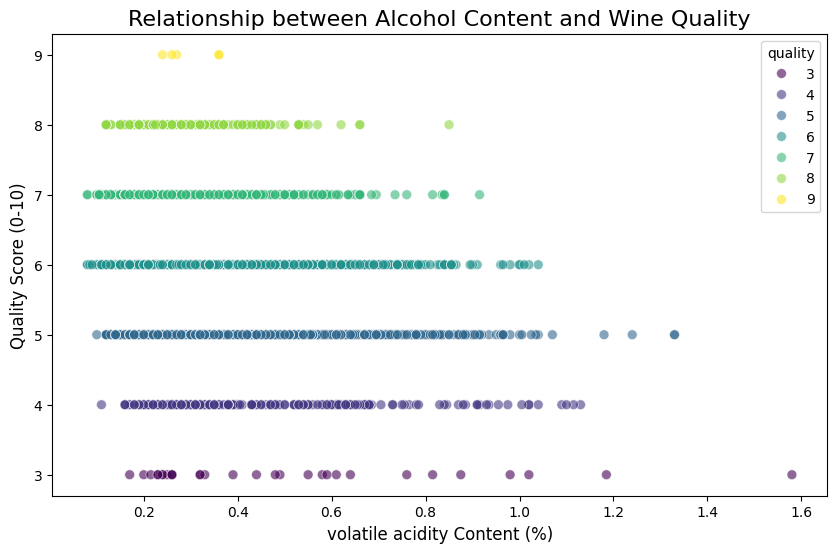

In [29]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='volatile acidity', y='quality', data=df, alpha=0.6,
                s=50,  # size of points
                hue='quality',  # color points based on quality score
                palette='viridis') # color scheme

# Add labels and a title
plt.title('Relationship between Alcohol Content and Wine Quality', fontsize=16)
plt.xlabel('volatile acidity Content (%)', fontsize=12)
plt.ylabel('Quality Score (0-10)', fontsize=12)

# Ensure the y-axis only shows integer quality scores
plt.yticks(df['quality'].unique())

# Save the figure
plt.savefig('alcohol_vs_quality_scatter.png')
plt.show()

Now we are going to check if there is a relation between Density Content and wine quality by using a scatter plot

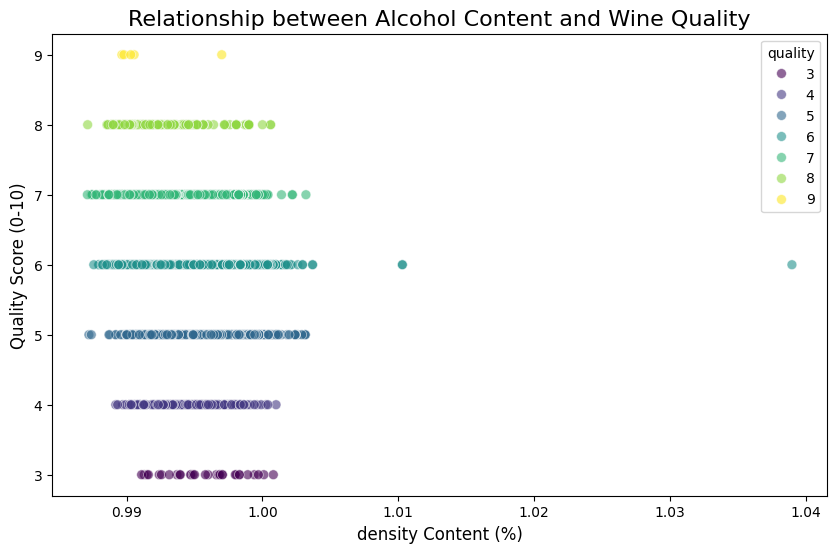

In [30]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='density', y='quality', data=df, alpha=0.6,
                s=50,  # size of points
                hue='quality',  # color points based on quality score
                palette='viridis') # color scheme

# Add labels and a title
plt.title('Relationship between Alcohol Content and Wine Quality', fontsize=16)
plt.xlabel('density Content (%)', fontsize=12)
plt.ylabel('Quality Score (0-10)', fontsize=12)

# Ensure the y-axis only shows integer quality scores
plt.yticks(df['quality'].unique())

# Save the figure
plt.savefig('alcohol_vs_quality_scatter.png')
plt.show()

Wine Quality Counts

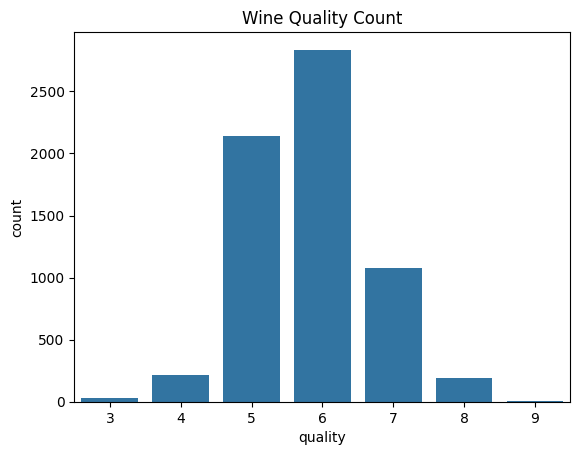

In [33]:
sns.countplot(x="quality", data=df)
plt.title("Wine Quality Count")
plt.show()